# Hybrid EfficientNet Swin Transformer 

This notebook shows the implementation of **Hybrid EfficientNet Swin Transformer (HENetSwinT)** model, with the training script for **TPU** and also inference code for **GPU**. Such approach (**HENetSwinT**) was used in [Google Landmark Recognition 2021](https://www.kaggle.com/c/landmark-recognition-2021) competition by [Dieter](https://www.kaggle.com/christofhenkel) originally written in PyTorch, solution explained [here](https://www.kaggle.com/c/landmark-recognition-2021/discussion/277098) in great details. In this notebook, we'll try to accomplish it in `tf.keras`. The whole hybrid architecture (**HENetSwinT**) looks something like as follows:

![](https://i.imgur.com/2iXNuBA.png)

<div align="center">
  Model Architecture of Hybrid EfficientNet Swin Transformer (HENetSwinT)
</div>

## Abstraction 

- In the given [cat-dog pet dataset](https://www.kaggle.com/c/petfinder-pawpularity-score/data), both image files and also meta informations are provided which can be used in training. The overall task is to analyze this raw images and metadata to predict the **Pawpularity** of pet photos. The target labels are given as a continuous quantity. The leaderboard score will be evaluated by **Root Mean Squared Error (RMSE)**, ([details](https://www.kaggle.com/c/petfinder-pawpularity-score/overview/evaluation)). So, we can frame this task as a regression category.

- Though it's regression problem, it's shared by the community that it might be better to treat such regression problem as a classification problem. It's done by normalizing the regression labels within `0-1` range and use cross-entropy as a loss function. In this code example, we will do the same. More details are [here](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/275094).

- For the modeling part, we first train a vision model on the **N** fold of the given samples. After training with the all folds, we'll take average of them and extract the features (embeddings) from the image files and further use it to train [CatBoost](https://catboost.ai/) model with another **N** folds. For the vision mdoel, we'll be using the **Hybrid-Swin Transformer** as described above. 

- The whole modeling approach is for **Experimentational** purposes. We can do different type of modeling approach in the same setup, dicussed in the another code examples, [Hybrid External MHA Transformer + RAPIS SVR](https://www.kaggle.com/ipythonx/hybrid-external-mha-transformer-rapis-svr) - [Discussion](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/286973). In summary, we can take both deep-network model's prediction and catboost model's prediction and then take average of them. 

- Also, here we're not using the given structural data yet. But of course, one can build a multi-input vision model that take image data and structure data; that is shown in this [notebook](https://www.kaggle.com/ipythonx/hybrid-external-mha-transformer-rapis-svr). For modeling with structure data or meta information, we can use one of the following models: 
    - [TF-Decision-Forests](https://www.tensorflow.org/decision_forests) - [Discussion and Starter](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/275182). 
    - [Behavior Sequence Transformer for Structured Data](https://arxiv.org/pdf/1905.06874.pdf) - [Discussion](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/287421) - [Starter](https://keras.io/examples/structured_data/movielens_recommendations_transformers/).

<div class = "alert alert-block alert-info">
    <h3><font color = "red">ATTENTION</font></h3>
<ul>
  <li>This notebook is configured to train the <strong>swin-transformer</strong> mdoel on <strong>TPU</strong>. But we already did train on TPU and saved the weights files (../input/pet-test-wg).
  <li>So, this notebook uses the trained embeddings of the <strong>swin-transformer</strong> and uses for next stage training with <strong>CatBoost</strong> model followed by inference.</li>
  <li>Additionally, from the above diagram, we made few changes in the architecture. We've used image size <code>896</code> to train the <strong>EfficientNetB0</strong> and use layer <code>blcok2b_add: (None, 224, 224, 24)</code> embeddings for <strong>swin-transformer</strong>. The final output of <strong>EfficientNet</strong> also gets concated with the <strong>swin-transformer's</strong> output. </li>
    <li>Reference: https://github.com/innat/EfficientNet-Hybrid-Swin-Transformer</li>
</ul>
</div>

So, the overal model architectue in this notebook would be:

![download](https://user-images.githubusercontent.com/17668390/139668055-2d19ea63-25cc-4665-b711-749c54b97a40.png)


---

**DISCLAIMER**

- The implementation of swin-transformer in `tf.keras` is mostly borrowed from [rishigami/Swin-Transformer-TF ](https://github.com/rishigami/Swin-Transformer-TF).
- For general training pipelines for next stage training (catbost model), we'll be using [ROBIN SMITS](https://www.kaggle.com/rsmits/effnet-b2-feature-models-catboost)'s great kernel. 

In [1]:
import numpy as np
import pandas as pd
import gc,random, os, sys, pickle
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf ; print(tf.__version__)
from tensorflow import keras 
from tensorflow.keras import backend as K 

tf.config.optimizer.set_jit(True)
physical_devices = tf.config.list_physical_devices('GPU')
try: tf.config.experimental.set_memory_growth(physical_devices[0], True)
except: pass 

sys.path.append('../input/swintransformertf')
from swintransformer import SwinTransformer

2.6.4


In [2]:
SwinTransformer?

In [3]:
CFGS = {
    'swin_tiny_224' : dict(input_size=(224, 224), window_size=7,  embed_dim=96,  
                           depths=[2, 2, 6, 2],  num_heads=[3, 6, 12, 24]),
    
    'swin_small_224': dict(input_size=(224, 224), window_size=7,  embed_dim=96,  
                           depths=[2, 2, 18, 2], num_heads=[3, 6, 12, 24]),
    
    'swin_base_224' : dict(input_size=(224, 224), window_size=7,  embed_dim=128, 
                           depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    
    'swin_base_384' : dict(input_size=(384, 384), window_size=12, embed_dim=128, 
                           depths=[2, 2, 18, 2], num_heads=[4, 8, 16, 32]),
    
    'swin_large_224': dict(input_size=(224, 224), window_size=7,  embed_dim=192, 
                           depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48]),
    
    'swin_large_384': dict(input_size=(384, 384), window_size=12, embed_dim=192, 
                           depths=[2, 2, 18, 2], num_heads=[6, 12, 24, 48])
}

**TPU / GPU Config**

In [4]:
# set 'TPU' for train + enable internet.
DEVICE = 'GPU' 

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        # ISSUE: PERFORMANCE PENALTY, BE AWARE!!!
        tf.config.set_soft_device_placement(True) 
        
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", 
          len(tf.config.experimental.list_physical_devices('GPU')))
    
AUTO     = tf.data.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


In [5]:
Q = 30
IMG_SIZE   = 896
BATCH_SIZE = 12
CHANNELS   = 3

EPOCHS = 30
FOLDS  = 10
SEED   = 987

VERBOSE = 1
LR      = 0.000005

FEATURE_FOLDS = 10

if DEVICE == "TPU":
    from kaggle_datasets import KaggleDatasets
    DATA_DIR = '/kaggle/input/petfinder-pawpularity-score/'
    GCS_PATH  = KaggleDatasets().get_gcs_path('petfinder-pawpularity-score')
    TRAIN_DIR = GCS_PATH + '/train/'
    TEST_DIR  = GCS_PATH + '/test/'
    FEATURE_TRAIN = True 
else:
    DATA_DIR  = '/kaggle/input/petfinder-pawpularity-score/'
    TRAIN_DIR = DATA_DIR + 'train/'
    TEST_DIR  = DATA_DIR + 'test/'
    FEATURE_TRAIN = False

In [6]:
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s) 
    
seed_all(SEED)

# Load Train Data
train_df = pd.read_csv(f'{DATA_DIR}train.csv')
train_df['Id'] = train_df['Id'].apply(lambda x: f'{TRAIN_DIR}{x}.jpg')

# Set a specific label to be able to perform stratification
# train_df.Pawpularity.max(), train_df.Pawpularity.min() <- (100, 1)
train_df['stratify_label'] = pd.qcut(train_df['Pawpularity'], q = Q, labels = range(Q))

# Label value to be used for feature model 'classification' training.
train_df['target_value'] = train_df['Pawpularity'] / 100. # normalizing 

# Summary
print(f'train_df: {train_df.shape}')
train_df.head()

train_df: (9912, 16)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,stratify_label,target_value
0,/kaggle/input/petfinder-pawpularity-score/trai...,0,1,1,1,0,0,1,0,0,0,0,0,63,26,0.63
1,/kaggle/input/petfinder-pawpularity-score/trai...,0,1,1,0,0,0,0,0,0,0,0,0,42,20,0.42
2,/kaggle/input/petfinder-pawpularity-score/trai...,0,1,1,1,0,0,0,0,1,1,0,0,28,9,0.28
3,/kaggle/input/petfinder-pawpularity-score/trai...,0,1,1,1,0,0,0,0,0,0,0,0,15,2,0.15
4,/kaggle/input/petfinder-pawpularity-score/trai...,0,0,0,1,0,0,1,0,0,0,0,0,72,27,0.72


In [7]:
# Load Test Data
test_df = pd.read_csv(f'{DATA_DIR}test.csv')
test_df['Id'] = test_df['Id'].apply(lambda x: f'{TEST_DIR}{x}.jpg')
test_df['Pawpularity'] = 0

# Summary
print(f'test_df: {test_df.shape}')
test_df.head()

test_df: (8, 14)


,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,/kaggle/input/petfinder-pawpularity-score/test...,1,0,1,0,0,1,1,0,0,1,0,1,0
1,/kaggle/input/petfinder-pawpularity-score/test...,0,1,0,0,0,0,1,1,0,0,0,0,0
2,/kaggle/input/petfinder-pawpularity-score/test...,0,0,0,1,0,1,1,1,0,1,1,1,0
3,/kaggle/input/petfinder-pawpularity-score/test...,1,0,1,0,0,0,0,0,0,0,1,0,0
4,/kaggle/input/petfinder-pawpularity-score/test...,1,1,1,0,1,1,0,1,0,1,1,0,0


# TF Dataset

In [8]:
# SetAutoTune
AUTOTUNE = tf.data.AUTOTUNE  

def build_augmenter(is_labelled):
    def augment(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.random_saturation(img, 0.95, 1.05)
        img = tf.image.random_brightness(img, 0.05)
        img = tf.image.random_contrast(img, 0.95, 1.05)
        img = tf.image.random_hue(img, 0.05)
        return img
    def augment_with_labels(img, label):
        return augment(img), label
    return augment_with_labels if is_labelled else augment

def build_decoder(is_labelled):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.image.decode_jpeg(file_bytes, channels = CHANNELS)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        return img
    def decode_with_labels(path, label):
        return decode(path), label
    return decode_with_labels if is_labelled else decode

def create_dataset(df, 
                   batch_size     = 32, 
                   is_labelled    = False, 
                   augment        = False, 
                   repeat         = False, 
                   shuffle        = False):
    decode_fn    = build_decoder(is_labelled)
    augmenter_fn = build_augmenter(is_labelled)
    
    # Create Dataset
    if is_labelled:
        dataset = tf.data.Dataset.from_tensor_slices((df['Id'].values, 
                                                      df['target_value'].values))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((df['Id'].values))
    dataset = dataset.map(decode_fn, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(augmenter_fn, num_parallel_calls=AUTOTUNE) if augment else dataset
    dataset = dataset.repeat() if repeat else dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.batch(batch_size*REPLICAS, drop_remainder=FEATURE_TRAIN)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

# Modeling
![](https://i.imgur.com/2iXNuBA.png)


### Change-Logs

- **No Subcenter Arcface Head**
- **EfficientNet B0 + Swin-Transformers**
- **Modification: Please see the `Attention` note at the beginning.**

**Checking**

In [9]:
from tensorflow.keras import applications

check_base = applications.EfficientNetB0(
    include_top=False,
    weights=None,
    input_tensor=keras.Input((896, 896, 3))
    )

for l in check_base.layers:
    print(l.name, l.output_shape)
    break
    
block2b_add = (None, 224, 224, 24)

input_1 [(None, 896, 896, 3)]


# Efficient Hybrid Swin-Transformer 

In [10]:
EfficientNetWeightsPath = '../input/efficientnet-keras-noisystudent-weights-b0b7/'

if DEVICE == "TPU": # TRUE for Training 
    efnet_wg = f"{EfficientNetWeightsPath}noisystudent/noisy.student.notop-b0.h5"
    swins_wg = True
    use_tpu  = True
    
else: # TRUE for Inference 
    efnet_wg = None
    swins_wg = False
    use_tpu  = False

In [11]:
class EfficientHybridSwinTransformer(keras.Model):
    def __init__(self):
        super(EfficientHybridSwinTransformer, self).__init__()
        # base models 
        self.inputx = keras.Input((IMG_SIZE, IMG_SIZE, CHANNELS), name='input_hybrids')
        base = applications.EfficientNetB0(
            include_top  = False,
            weights      = efnet_wg,
            input_tensor = self.inputx
        )
        for layer in base.layers:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
            else:
                layer.trainable = False

        # base model with compatible output which will be an input of transformer model 
        self.new_base = keras.Model(
            [base.inputs], 
            [base.get_layer('block2b_add').output, base.output], # output with 224 feat_maps
            name='efficientnet'
        )
        self.conv = keras.layers.Conv2D(3, 3, padding='same')
        self.swin_blocks = SwinTransformer('swin_large_224', 
                                           num_classes=1, 
                                           include_top=False, 
                                           pretrained=swins_wg, 
                                           use_tpu=use_tpu, 
                                           cfgs=CFGS)
        self.fc = keras.layers.Dense(1, activation = 'sigmoid')

    # calling 
    def call(self, inputs, training=None, **kwargs):
        base_x, base_y = self.new_base(inputs)
        from_swin = self.swin_blocks(self.conv(base_x))
        cating = tf.concat([from_swin, 
                            keras.layers.GlobalAveragePooling2D()(base_y)], axis=-1)
        if training:
            return self.fc(cating)
        else:
            return self.fc(cating), cating # need cating o/p in inference time. 

    def build_graph(self):
        x = keras.Input(shape=(IMG_SIZE, IMG_SIZE, CHANNELS))
        return keras.Model(inputs=[x], outputs=self.call(x))

(1, 1)


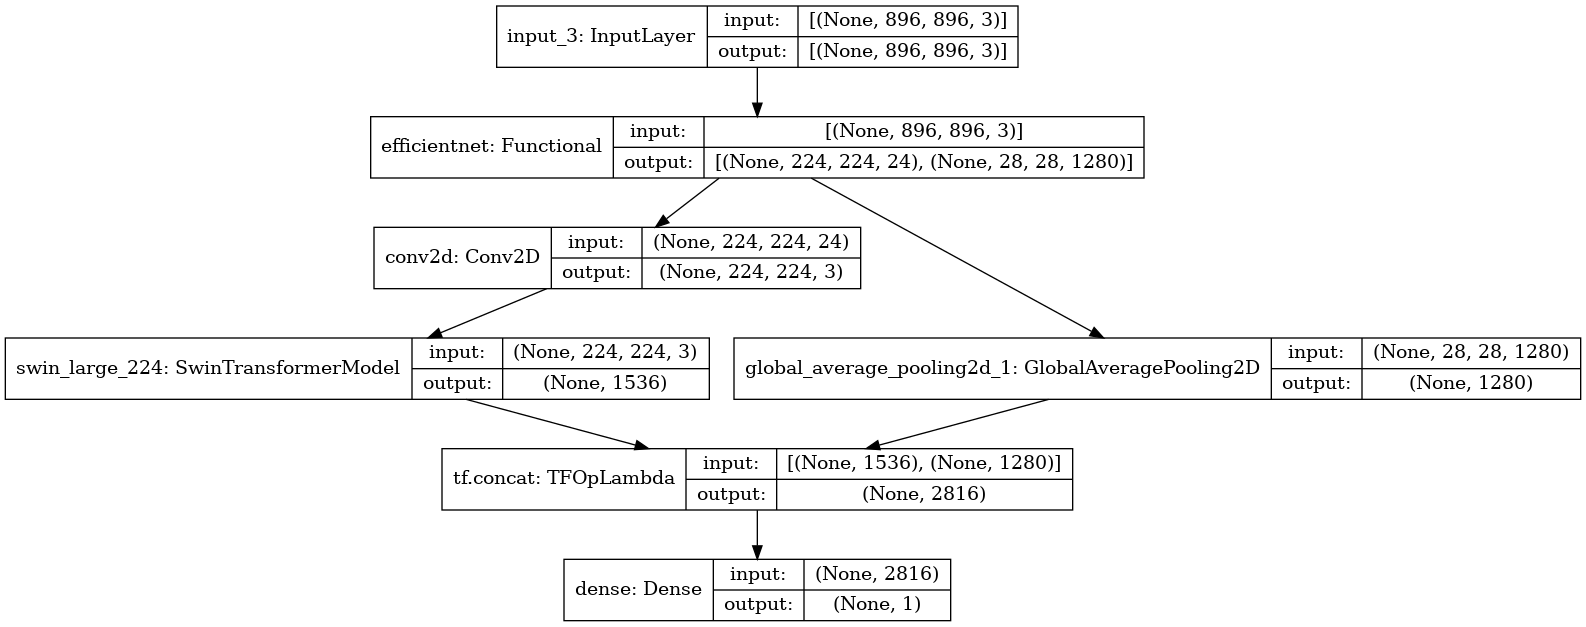

(1, 1)
Model: "efficient_hybrid_swin_transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet (Functional)    [(None, 224, 224, 24), (N 4049571   
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       651       
_________________________________________________________________
swin_large_224 (SwinTransfor (None, 1536)              195331616 
_________________________________________________________________
dense (Dense)                (None, 1)                 2817      
Total params: 199,384,655
Trainable params: 198,964,476
Non-trainable params: 420,179
_________________________________________________________________
None


In [12]:
def get_model(plot_model, print_summary, with_compile):
    model = EfficientHybridSwinTransformer()

    if plot_model:
        print(model(tf.ones((1, IMG_SIZE, IMG_SIZE, CHANNELS)))[0].shape)
        display(keras.utils.plot_model(model.build_graph(), 
                                          show_shapes=True, 
                                          show_layer_names=True,
                                          expand_nested=False))
    if print_summary:
        print(model(tf.ones((1, IMG_SIZE, IMG_SIZE, CHANNELS)))[0].shape)
        print(model.summary())
        
    if with_compile:
        print(model(tf.ones((1, IMG_SIZE, IMG_SIZE, CHANNELS)))[0].shape)
        model.compile(
            optimizer = keras.optimizers.Adam(learning_rate = LR), 
            loss = keras.losses.BinaryCrossentropy(), 
            metrics = [keras.metrics.RootMeanSquaredError('rmse')])  
        
    return model 

model = get_model(plot_model    = True,
                  print_summary = True, 
                  with_compile  = False)

# Train: Feature Extractor : Hybrid Swin Transformer

In [13]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * batch_size * REPLICAS
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        return lr
    return keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


# Set Callbacks
def model_checkpoint(fold):
    return keras.callbacks.ModelCheckpoint(f'feature_models_{fold}.h5',
                                           verbose = 1, 
                                           monitor = 'val_rmse', 
                                           mode    = 'min', 
                                           save_weights_only = True,
                                           save_best_only    = True)

## Note

As we already train the hybrid model in **TPU**, that's why here we skip the training part on tpu. That's why we set, `FEATURE_TRAIN == FALSE`.

In [14]:
if FEATURE_TRAIN: # TRUE if DEVICE == TPU 
    # OOF RMSE Placeholder
    all_val_rmse = []

    # Stratified Training
    kfold = StratifiedKFold(n_splits = FEATURE_FOLDS, 
                            shuffle = True, random_state = SEED)

    for fold, (train_index, val_index) in enumerate(kfold.split(train_df.index,
                                                                train_df['stratify_label'])):
        if fold == 0: # Train on fold sequentially. 0,1,2,3,4,....FEATURE_FOLDS
            print(f'\nFold {fold}\n')
            # Pre model.fit cleanup
            tf.keras.backend.clear_session()
            gc.collect()

            # Create Model
            with strategy.scope():
                model = get_model(plot_model=False, print_summary=False, with_compile=True)

            # Create TF Datasets
            trn = train_df.iloc[train_index]
            val = train_df.iloc[val_index]
            training_dataset = create_dataset(trn, 
                                              batch_size  = BATCH_SIZE, 
                                              is_labelled = True, 
                                              augment     = True, 
                                              repeat      = True, 
                                              shuffle     = True)
            validation_dataset = create_dataset(val, 
                                                batch_size  = BATCH_SIZE, 
                                                is_labelled = True,
                                                augment     = False, 
                                                repeat      = True, 
                                                shuffle     = False)

            # Fit Model
            history = model.fit(training_dataset,
                                epochs = EPOCHS,
                                steps_per_epoch  = trn.shape[0] / BATCH_SIZE // REPLICAS,
                                validation_steps = val.shape[0] / BATCH_SIZE // REPLICAS,
                                callbacks = [model_checkpoint(fold), get_lr_callback(BATCH_SIZE)],
                                validation_data = validation_dataset,
                                verbose = 1)   

            # Validation Information
            best_val_rmse = min(history.history['val_rmse'])
            all_val_rmse.append(best_val_rmse)
            print(f'\nValidation RMSE: {best_val_rmse}\n')

    # Summary
    print(f'Final Mean RMSE for {FEATURE_FOLDS} Fold CV Training: {np.mean(all_val_rmse)}')

# CatBoost 10 Fold CV Training + Ensemble Inference

Here, we use `CatBoost` but we can also try [RAPIDS SVR](https://www.kaggle.com/cdeotte/rapids-svr-boost-17-8). However, here is the workflow:

- We take Image Model embeddings and use it to `CatBoost` model.
- Again, we trained `10` fold of the Image Model, so that gives `10` weights. So next, we will average these Image Models.
- After that, we will do another `10` fold for the `CatBost` mdoel. 

If you're confuse somehow about **why swin transformer** and **why now catboost model**, then please see the below diagram for clarification. In the first stage we used hybrid swin transformer and trained this model as classification model. And after training, we want to extract the feature of the image by this trained model (from stage 1) and use these features as a input for next stage training. In the next stage training, we use catboost model and will train it with regression loss function (RMSE). 

![Presentation1](https://user-images.githubusercontent.com/17668390/149220379-e91edde9-3d71-4d11-bb09-4679de292c67.png)

In [15]:
# Placeholders
preds_final   = np.zeros((test_df.shape[0], 1))
all_oof_score = []

# Stratification and Label values
Y_strat = train_df['stratify_label'].values
Y_pawpularity = train_df['Pawpularity'].values

**Image Model's Weights Ensemble**

- 10 Image Model Weights for 10  FOLDS Training.
- Take Average. 
- Use the Averaged Weights.

In [16]:
# CV: 0.1880158931016922
model_a = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_a.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_0.h5', by_name=True)

# CV: 0.1864963173866272
model_b = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_b.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_1.h5', by_name=True)

# CV: 0.17805276811122894
model_c = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_c.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_2.h5', by_name=True)

# CV: 0.1805611252784729
model_d = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_d.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_3.h5', by_name=True)

# CV: 0.18030136823654175
model_e = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_e.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_4.h5', by_name=True)

# CV: 0.18239009380340576
model_f = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_f.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_5.h5', by_name=True)

# CV: 0.17896604537963867
model_g = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_g.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_6.h5', by_name=True)

# CV: 0.1817626655101776
model_h = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_h.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_7.h5', by_name=True)

# CV: 0.18311156332492828
model_i = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_i.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_8.h5', by_name=True)

# CV: 0.17778289318084717
model_j = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model_j.load_weights('../input/pet-test-wg/hyb_eff_attn_wg/feature_models_9.h5', by_name=True)

# ALL Hybrid-Swins 
models = [model_a, model_b, model_c, model_d, model_e, 
          model_f, model_g, model_h, model_i, model_j]
weights = [model.get_weights() for model in models]

# Mnaully Averaging 
new_weights = list()
for weights_list_tuple in zip(*weights): 
    if weights_list_tuple[0].any() != 0:
        new_weights.append(
            np.array([np.array(w).mean(axis=0) for w in zip(*weights_list_tuple)])
        )
    else:
        new_weights.append(np.array(weights_list_tuple).mean(axis=0))
        
# Set the New Averaged Weights
model = get_model(plot_model=False,  print_summary=False,  with_compile=True)
model.set_weights(new_weights)
model.save_weights('merged_hybrid_10folds.h5')

(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)


**Get Embeddings from Image Model** 

- In previous section, we took average of the `10` image models.
- Next, we will use that **average weight** to get embeddings of the image files.
- Next, fit them on `CatBoost` Model.


In [17]:
# Pre model.fit cleanup
K.clear_session()
gc.collect()

# Feature Extraction
print('\nExtracting Features')
cb_train_set = create_dataset(train_df, 
                              batch_size  = BATCH_SIZE, 
                              is_labelled = True, 
                              augment     = False,
                              repeat      = False, 
                              shuffle     = False)
cb_test_set = create_dataset(test_df, 
                             batch_size  = BATCH_SIZE,
                             is_labelled = False, 
                             augment     = False, 
                             repeat      = False, 
                             shuffle     = False)

cb_train_features = model.predict(cb_train_set, verbose = VERBOSE)[1]
cb_test_features  = model.predict(cb_test_set, verbose = VERBOSE)[1]

# Feature Set Shapes
print(f'Train Feature Set Shape: {cb_train_features.shape}')
print(f'Test Feature Set Shape : {cb_test_features.shape}')


Extracting Features
1/1 [==============================] - 25s 25s/step
Train Feature Set Shape: (9912, 2816)
Test Feature Set Shape : (8, 2816)


# Next Step : CatBoost Modeling

- In previous section, we first average all `10` model weights. 
- Next, we used that averaged weights and compute image embeddings in the previous cell.
- Now, we can use this image embeddings to train `CatBoost` (or `SVR` if we want). 
- In the next cell, we can set `CAT_BOOST_TRAIN` to `True` to start training, Or,
- We can simply reload the trained cat-boost models. 

In [18]:
CAT_BOOST_TRAIN = False
LOAD_CAT_FROM_PATH = '../input/pet-test-wg/catboost/'

# Placeholders
oof_score = []

kfold = StratifiedKFold(n_splits = FOLDS, shuffle  = True, random_state = SEED)

for idx, (train, val) in enumerate(kfold.split(cb_train_features, Y_strat)):
    print(f'\n----- CatBoost Fold {idx} -----')
    
    train_x, train_y = cb_train_features[train], Y_pawpularity[train]
    val_x, val_y     = cb_train_features[val], Y_pawpularity[val]

    # Set CatBoost Parameters
    cb_params = {'loss_function'   : 'RMSE',
                 'eval_metric'     : 'RMSE',
                 'iterations'      :  1000,
                 'grow_policy'     : 'SymmetricTree',
                 'depth'           :   6,
                 'l2_leaf_reg'     : 2.0,
                 'random_strength' : 1.0,
                 'learning_rate'   : 0.05,
                 'task_type'       : 'CPU',
                 'devices'         : '0',
                 'verbose'         :  0,
                 'random_state'    : SEED}

    name = f"catboost_fold_{idx}.pkl"
    
    if CAT_BOOST_TRAIN:
        # Create and Fit CatBoost Model
        cb_model = CatBoostRegressor(**cb_params)
        cb_model.fit(train_x, train_y, 
                     eval_set = [(val_x, val_y)],
                     early_stopping_rounds = 100, 
                     verbose = 250)
        pickle.dump(cb_model, open(name, "wb"))
    else:
        print('Loading Catboost...',LOAD_CAT_FROM_PATH+name)
        cb_model = pickle.load(open(LOAD_CAT_FROM_PATH+name, "rb"))

    # pred on test 
    preds_final += np.array([cb_model.predict(cb_test_features)]).T
    
    # Update OOF Score
    y_pred = cb_model.predict(val_x)
    oof_score.append(np.sqrt(mean_squared_error(val_y, y_pred)))       

    # Cleanup
    del cb_model, y_pred
    del train_x, train_y
    del val_x, val_y
    gc.collect()   

    # OOF Score for CatBoost run
    print(f'CatBoost OOF Score: {oof_score[-1]}')
    # Increase to improve randomness on the next feature model run
    SEED += 1
    
# Final OOF score for All Feature Models
print(f'\n\nFinal OOF RMSE Score for all feature models: {np.mean(oof_score)}')


----- CatBoost Fold 0 -----
Loading Catboost... ../input/pet-test-wg/catboost/catboost_fold_0.pkl
CatBoost OOF Score: 17.549278037575505

----- CatBoost Fold 1 -----
Loading Catboost... ../input/pet-test-wg/catboost/catboost_fold_1.pkl
CatBoost OOF Score: 17.464352819036648

----- CatBoost Fold 2 -----
Loading Catboost... ../input/pet-test-wg/catboost/catboost_fold_2.pkl
CatBoost OOF Score: 16.916250267634947

----- CatBoost Fold 3 -----
Loading Catboost... ../input/pet-test-wg/catboost/catboost_fold_3.pkl
CatBoost OOF Score: 17.273986938140162

----- CatBoost Fold 4 -----
Loading Catboost... ../input/pet-test-wg/catboost/catboost_fold_4.pkl
CatBoost OOF Score: 17.013440273259707

----- CatBoost Fold 5 -----
Loading Catboost... ../input/pet-test-wg/catboost/catboost_fold_5.pkl
CatBoost OOF Score: 16.90948551266169

----- CatBoost Fold 6 -----
Loading Catboost... ../input/pet-test-wg/catboost/catboost_fold_6.pkl
CatBoost OOF Score: 16.63326249888976

----- CatBoost Fold 7 -----
Loading

# Create Submission Files

In [19]:
preds_final /= FOLDS
submission_df = pd.read_csv(f'{DATA_DIR}sample_submission.csv')
submission_df['Pawpularity'] = preds_final.ravel()
submission_df.to_csv('submission.csv', index = False)

# Summary
submission_df.head(10)

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,59.056862
1,43a2262d7738e3d420d453815151079e,58.581950
2,4e429cead1848a298432a0acad014c9d,59.162782
3,80bc3ccafcc51b66303c2c263aa38486,58.997294
4,8f49844c382931444e68dffbe20228f4,59.478725
5,b03f7041962238a7c9d6537e22f9b017,58.224813
6,c978013571258ed6d4637f6e8cc9d6a3,59.357475
7,e0de453c1bffc20c22b072b34b54e50f,58.749556


# Additional Resources
1. **How to use it on my own dataset?**
    - First, understand the competition task and its data format. And try to relate with yours. 
    - Second, run this notebook successfully on the competition data. 
    - Lastly, replace the dataset with yours. 
2. **More Code Exampels.** 
    - [Hybrid External MHA Transformer + RAPIS SVR](https://www.kaggle.com/ipythonx/hybrid-external-mha-transformer-rapis-svr) - [Discussion](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/281917). 
    - [[TF.Keras]:Learning to Resize Images for ViT Model](https://www.kaggle.com/ipythonx/tf-keras-learning-to-resize-images-for-vit-model) - [Discussion](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/280438).
    - [Discussion: DOLG Models in TensorFlow 2 (Keras) Implementation](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/281914) - [TF.Keras Code](https://github.com/innat/DOLG-TensorFlow)
    - [TF: Hybrid EfficientNet Swin-Transformer : GradCAM](https://www.kaggle.com/ipythonx/tf-hybrid-efficientnet-swin-transformer-gradcam)